# Binary classification of machine failure using deep learning

In this notebook I'll try to tackle a binary classification problem of a dataset containing data of machine failures. The metric used will be AUC-ROC (area under the ROC curve) and I'll be using a deep learning model from Keras Tensorflow library.

# Summary
* About the dataset;
* Importing libraries;
* EDA & Feature Engineering;
* Modeling;
* Tuning;
* Results.

# About the dataset
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Machine Failure Predictions (https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions).

File format:
* Machine failure is the (binary) target (which, in order to align with the ordering of the original dataset, is not in the last column position);
* train.csv - the training dataset; 
* test.csv - the test dataset; 
* Your objective is to predict the probability of Machine failure;
* sample_submission.csv - a sample submission file in the correct format.

The table bellow shows every column and it's description( I've get this information from here: https://github.com/JMViJi/Binary-Classification-of-Machine-Failures)

| Column Header         | Description                                                                                                                                                                                            |
|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 'id'                  | This is a unique identifier assigned to each record in the dataset. It helps in indexing and referencing each individual record.                                                                    |
| 'Product Id'          | Combination of the 'Type' variable followed by an identifier number.                                                                                                                                   |
| 'Type'                | Refers to the type of machine for which the readings are recorded. Understanding the machine type can provide insights into its operations, which in turn can be linked to the probability of failure. |
| 'Air temperature [K]' | Ambient temperature around the machine, measured in Kelvin. Could influence machine behavior under different ambient conditions.                                                                       |
| 'Process temperature [K]' | Temperature of the process in which the machine is engaged, measured in Kelvin. Certain processes might lead to increased machine heat and failure likelihood.                      |
| 'Rotational speed [rpm]' | Operating speed of the machine, measured in rotations per minute (rpm). Higher speeds could contribute to increased wear and tear.                                                              |
| 'Torque [Nm]'         | Measure of the force causing the machine to rotate, expressed in Newton meters (Nm). High torque might indicate higher load and increased failure risk.                                             |
| 'Tool wear [min]'     | Indicates the degree of wear and tear experienced by the machine, measured in minutes. High tool wear may suggest the need for maintenance.                                                       |
| 'Machine failure'     | Target variable: binary indicator specifying whether the machine failed (1) or not (0).                                                                                                            |
| 'TWF'                 | Tool wear failure: indicates whether the machine failed due to tool wear.                                                                                                                             |
| 'HDF'                 | Heat dissipation failure: indicates whether the machine failed due to inadequate heat dissipation.                                                                                                |
| 'PWF'                 | Power failure: indicates whether the machine failed due to power-related issues.                                                                                                                    |
| 'OSF'                 | Overstrain failure: indicates whether the machine failed due to overstraining.                                                                                                                      |
| 'RNF'                 | Random failure: indicates whether the machine failed due to a random, unspecified issue.                                                                                                           |



#  Importing libraries
All the libraries used on this notebook will be here.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # plot data
%matplotlib inline

import seaborn as sns # better plot visualization
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import layers

from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


/tmp/ipykernel_20/1493585860.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


# EDA
From here I'll explore and try to understand more about the data.

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv', index_col='id')

In [3]:
df_train

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0


In [4]:
df_test

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


The dataset have only two categorical values, ProductId and Type, those are in the object type format.

In [6]:
df_train.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print(df_train.isna().sum())

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


The dataset doesn't have any null value.

In [8]:
df_train.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [9]:
cat_features = df_train[['Product ID', 'Type', 'Machine failure', 'TWF', 'HDF',
                         'PWF', 'OSF','RNF']]
num_features = df_train[['Air temperature [K]', 'Process temperature [K]', 
                         'Rotational speed [rpm]', 'Torque [Nm]',
                         'Tool wear [min]']]

### Categorical features

In [10]:
cat_features

,Product ID,Type,Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,
0,L50096,L,0,0,0,0,0,0
1,M20343,M,0,0,0,0,0,0
2,L49454,L,0,0,0,0,0,0
3,L53355,L,0,0,0,0,0,0
4,M24050,M,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
136424,M22284,M,0,0,0,0,0,0
136425,H38017,H,0,0,0,0,0,0
136426,L54690,L,0,0,0,0,0,0


The dataset already have a column to identify the type of a product, so I'll probably drop those letters on the Product ID.

In [11]:
def remove_letters(input_string):
    translation_table = str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result_string = input_string.translate(translation_table)
    return result_string

# Apply the function to each value in the column
cleaned_column = [remove_letters(value) for value in df_train['Product ID']]
cleaned_column_test = [remove_letters(value) for value in df_test['Product ID']]

df_train['Product ID'] = cleaned_column
df_test['Product ID'] = cleaned_column_test

cat_features

,Product ID,Type,Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,
0,L50096,L,0,0,0,0,0,0
1,M20343,M,0,0,0,0,0,0
2,L49454,L,0,0,0,0,0,0
3,L53355,L,0,0,0,0,0,0
4,M24050,M,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
136424,M22284,M,0,0,0,0,0,0
136425,H38017,H,0,0,0,0,0,0
136426,L54690,L,0,0,0,0,0,0


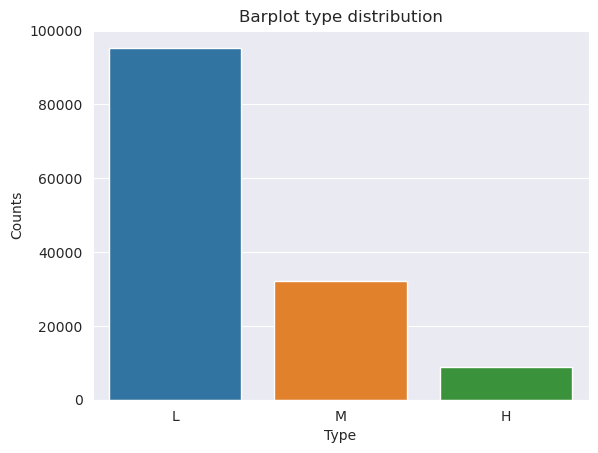

In [12]:
# Count how much machines have in each type
type_counts = cat_features['Type'].value_counts()

sns.barplot(x=type_counts.index,
            y=type_counts.values)

plt.title('Barplot type distribution')
plt.xlabel('Type')
plt.ylabel('Counts')
plt.show()

Now, I'll do a OneHotEncoding on 'type' column

In [13]:
df_test

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
227378,51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
227379,47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
227380,48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0


In [14]:
# One hot encoding on the train set
one_hot_encoder = OneHotEncoder()

# Transform 'Type' column in df_train
encoded_type = one_hot_encoder.fit_transform(df_train[['Type']]).toarray()

# Create a DataFrame with encoded values
encoded_df = pd.DataFrame(encoded_type, columns=one_hot_encoder.get_feature_names_out(['Type']))

# Concatenate encoded_df with df_train
df_train_encoded = pd.concat([df_train, encoded_df], axis=1)

df_train_encoded.drop('Type', axis=1, inplace=True)
df_train_encoded

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,50096,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,0.0,1.0,0.0
1,20343,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0.0,0.0,1.0
2,49454,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,0.0,1.0,0.0
3,53355,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,0.0,1.0,0.0
4,24050,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,22284,300.1,311.4,1530,37.5,210,0,0,0,0,0,0,0.0,0.0,1.0
136425,38017,297.5,308.5,1447,49.1,2,0,0,0,0,0,0,1.0,0.0,0.0
136426,54690,300.5,311.8,1524,38.5,214,0,0,0,0,0,0,0.0,1.0,0.0
136427,53876,301.7,310.9,1447,46.3,42,0,0,0,0,0,0,0.0,1.0,0.0


In [15]:
# One hot encoding on the test set
one_hot_encoder = OneHotEncoder()

# Transform 'Type' column in df_test
encoded_type = one_hot_encoder.fit_transform(df_test[['Type']]).toarray()

# Create a DataFrame with encoded values
encoded_df_test = pd.DataFrame(encoded_type, columns=one_hot_encoder.get_feature_names_out(['Type']))
encoded_df_test = encoded_df_test.set_index(df_test.index) # I've to set the index because the test dataframe doesn't start in id 0

# Concatenate encoded_df with df_train
df_test_encoded = pd.concat([df_test, encoded_df_test], axis=1)

df_test_encoded.drop('Type', axis=1, inplace=True)
df_test_encoded

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
id,,,,,,,,,,,,,,
136429,50896,302.3,311.5,1499,38.0,60,0,0,0,0,0,0.0,1.0,0.0
136430,53866,301.7,311.0,1713,28.8,17,0,0,0,0,0,0.0,1.0,0.0
136431,50498,301.3,310.4,1525,37.7,96,0,0,0,0,0,0.0,1.0,0.0
136432,21232,300.1,309.6,1479,47.6,5,0,0,0,0,0,0.0,0.0,1.0
136433,19751,303.4,312.3,1515,41.3,114,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227378,51130,302.3,311.4,1484,40.4,15,0,0,0,0,0,0.0,1.0,0.0
227379,47783,297.9,309.8,1542,33.8,31,0,0,0,0,0,0.0,1.0,0.0
227380,48097,295.6,306.2,1501,41.4,187,0,0,0,0,0,0.0,1.0,0.0


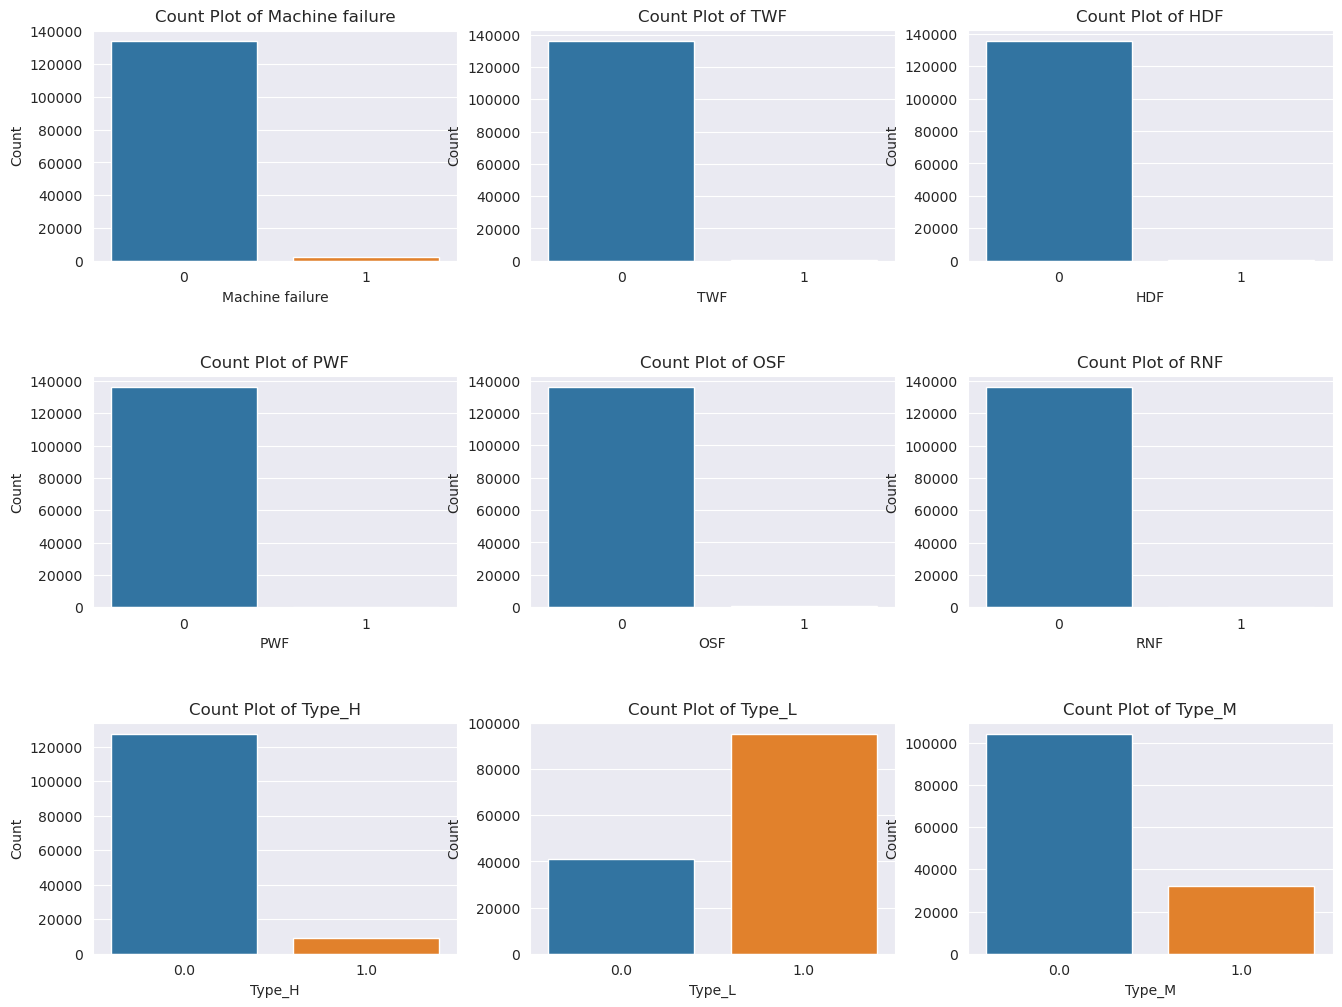

In [16]:
binary_features = ['Machine failure', 'TWF', 'HDF',
                   'PWF','OSF','RNF','Type_H','Type_L',
                   'Type_M']

# Set up the figure and axes
plt.figure(figsize=(16, 12))

# Create count plots for each categorical column
for i, column in enumerate(binary_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df_train_encoded, x=column)
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
plt.subplots_adjust(hspace=0.5)  # Adjust the value to control spacing

In [17]:
failure_counts = df_train_encoded['Machine failure'].value_counts()

# Print the counts
print("Occurrences of Machine Failure:")
print("Value 0:", failure_counts[0])
print("Value 1:", failure_counts[1])

Occurrences of Machine Failure:
Value 0: 134281
Value 1: 2148


The dataset has just a few failures, and most of the data are from the L type.

### Numerical features

In [18]:
num_features

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
id,,,,,
0,300.6,309.6,1596,36.1,140
1,302.6,312.1,1759,29.1,200
2,299.3,308.5,1805,26.5,25
3,301.0,310.9,1524,44.3,197
4,298.0,309.0,1641,35.4,34
...,...,...,...,...,...
136424,300.1,311.4,1530,37.5,210
136425,297.5,308.5,1447,49.1,2
136426,300.5,311.8,1524,38.5,214


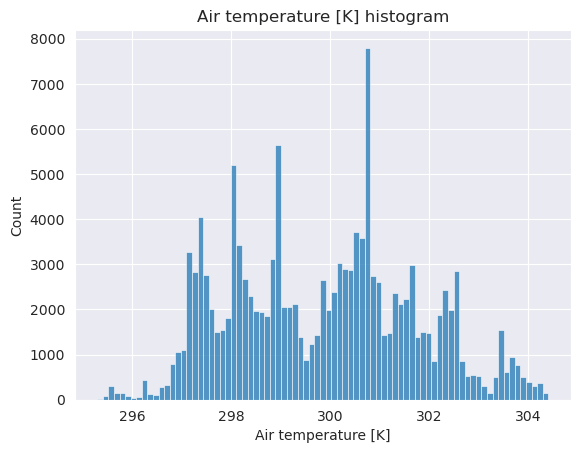

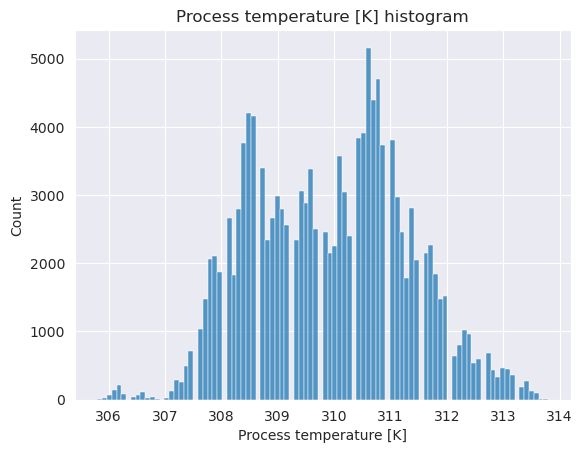

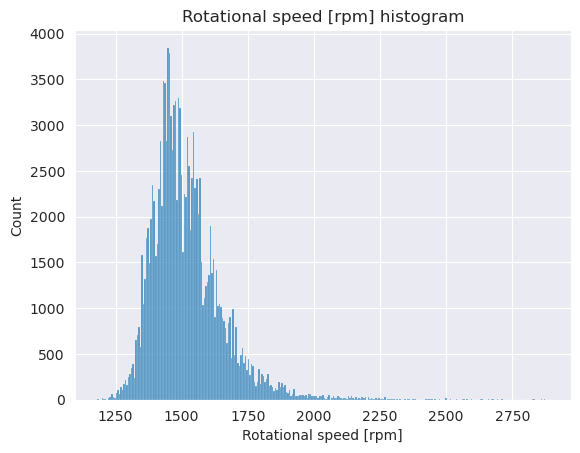

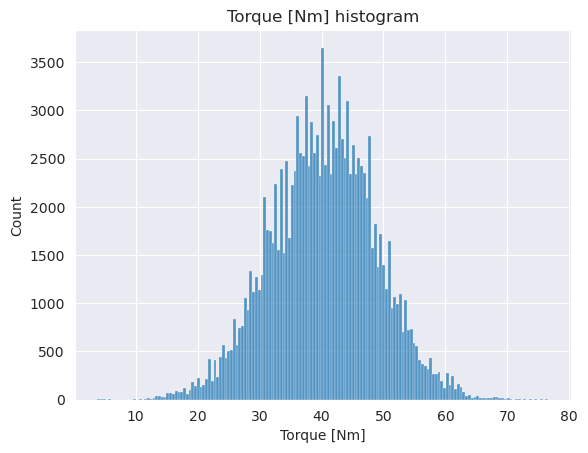

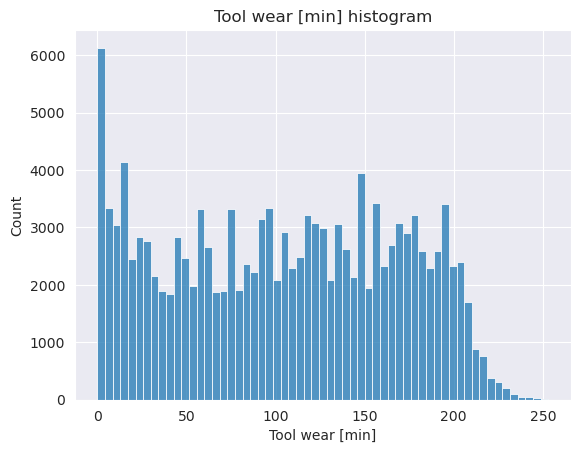

In [19]:
for col_name in num_features.columns:
    sns.histplot(num_features[col_name])
    plt.title(f'{col_name} histogram')
    plt.show()

Not all the numerical data is standardized, so I'll preprocess the data for that. This will probably be benefit for the deep learning model.

In [20]:
# Scalar for trainning set
scaler = StandardScaler()
# Select the numeric columns for standardization
numeric_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

df_train_encoded[numeric_columns] = scaler.fit_transform(df_train_encoded[numeric_columns])
num_features = df_train_encoded[numeric_columns]

In [21]:
# Scalar for test set
scaler = StandardScaler()
# Select the numeric columns for standardization
numeric_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

df_test_encoded[numeric_columns] = scaler.fit_transform(df_test_encoded[numeric_columns])

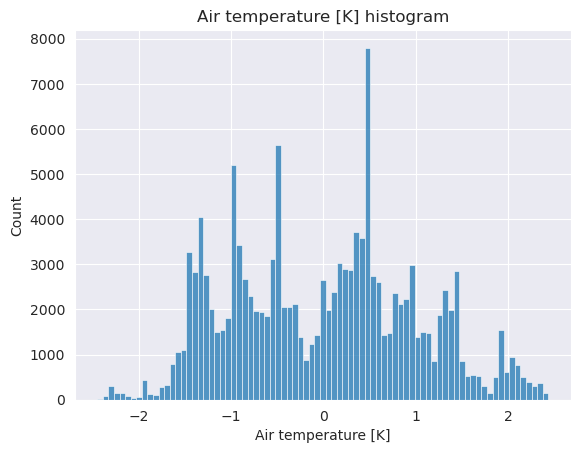

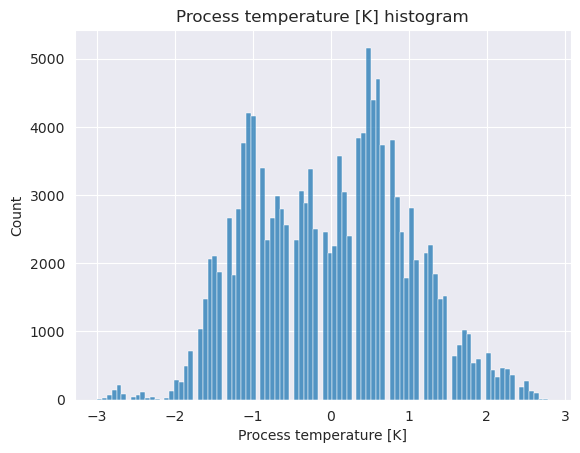

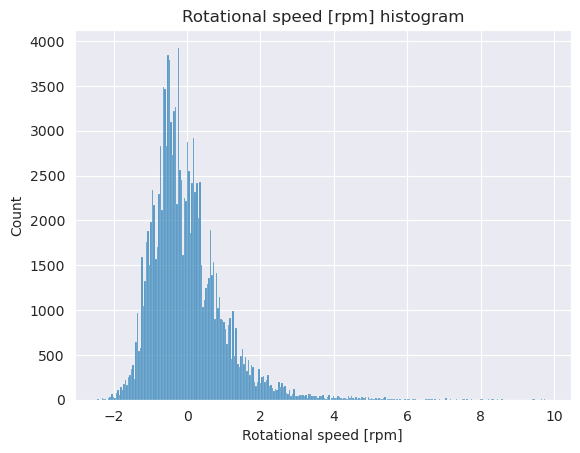

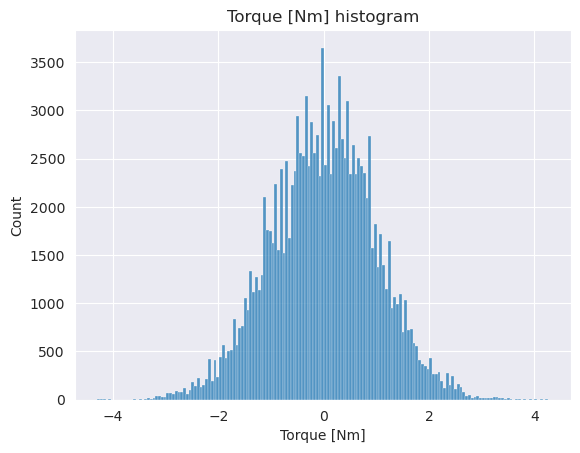

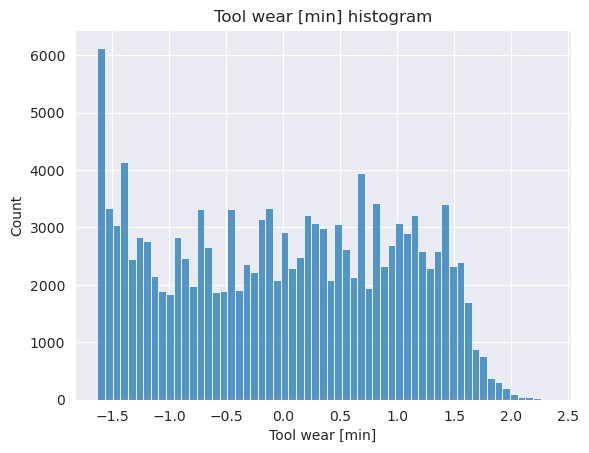

In [22]:
for col_name in num_features.columns:
    sns.histplot(num_features[col_name])
    plt.title(f'{col_name} histogram')
    plt.show()

/tmp/ipykernel_20/634092389.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train_encoded.corr()


Text(0.5, 1.0, 'Correlation Heatmap')

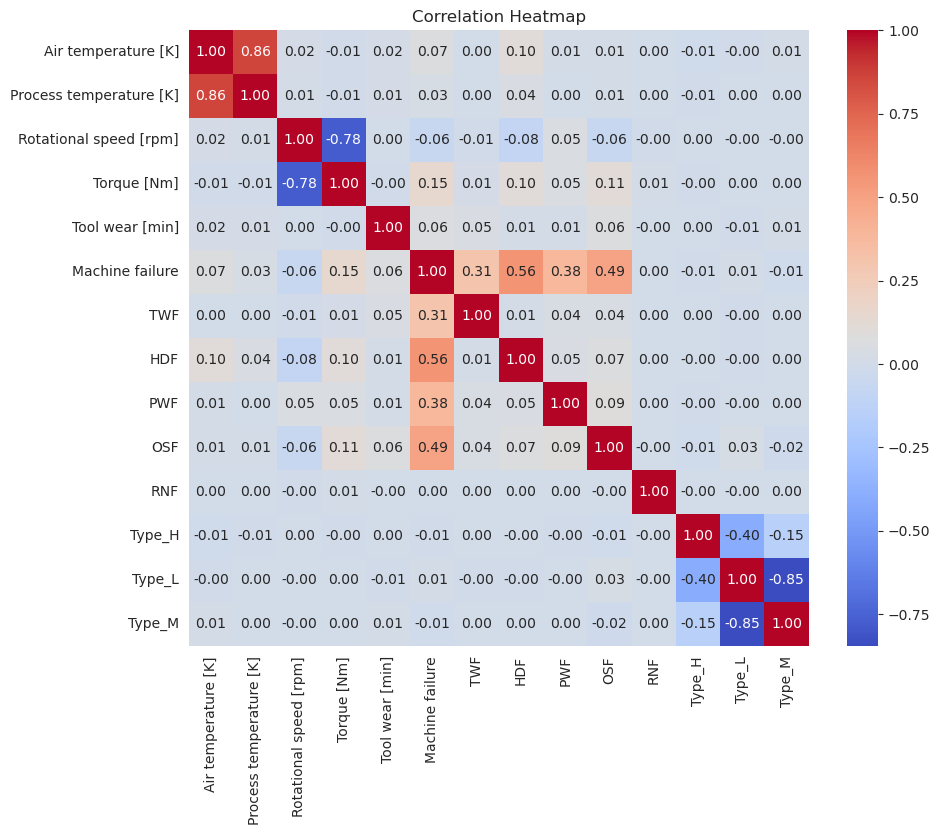

In [23]:
# Compute the correlation matrix
correlation_matrix = df_train_encoded.corr()

# Set up the figure and axes
plt.figure(figsize=(10, 8))

# Create the heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set plot title
plt.title('Correlation Heatmap')

I'll drop ProductID to, because it doens't affect the model performance

In [24]:
ids = df_test_encoded['Product ID']

df_train_encoded = df_train_encoded.drop('Product ID', axis=1)
df_test_encoded = df_test_encoded.drop('Product ID', axis=1)

In [25]:
df_train_encoded

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,0,0,0,0,0,0,0.0,1.0,0.0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,0,0,0,0,0,0,0.0,0.0,1.0
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,0,0,0,0,0,0,0.0,1.0,0.0
3,0.610675,0.692284,0.026445,0.464745,1.447532,0,0,0,0,0,0,0.0,1.0,0.0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,0,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,0.127386,1.053251,0.069693,-0.335048,1.650769,0,0,0,0,0,0,0.0,0.0,1.0
136425,-1.268781,-1.040358,-0.528565,1.029305,-1.601020,0,0,0,0,0,0,1.0,0.0,0.0
136426,0.342182,1.342025,0.026445,-0.217431,1.713303,0,0,0,0,0,0,0.0,1.0,0.0
136427,0.986567,0.692284,-0.528565,0.699979,-0.975676,0,0,0,0,0,0,0.0,1.0,0.0


In [26]:
df_test_encoded

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
id,,,,,,,,,,,,,
136429,1.313830,1.126570,-0.153806,-0.274579,-0.693494,0,0,0,0,0,0.0,1.0,0.0
136430,0.990824,0.765635,1.375097,-1.356341,-1.366729,0,0,0,0,0,0.0,1.0,0.0
136431,0.775487,0.332512,0.031949,-0.309854,-0.129855,0,0,0,0,0,0.0,1.0,0.0
136432,0.129475,-0.244985,-0.296694,0.854217,-1.554608,0,0,0,0,0,0.0,0.0,1.0
136433,1.906008,1.704068,-0.039496,0.113445,0.151964,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227378,1.313830,1.054383,-0.260972,0.007620,-1.398042,0,0,0,0,0,0.0,1.0,0.0
227379,-1.054879,-0.100611,0.153403,-0.768427,-1.147536,0,0,0,0,0,0.0,1.0,0.0
227380,-2.293068,-2.699348,-0.139517,0.125203,1.294897,0,0,0,0,0,0.0,1.0,0.0


# Modeling
Now I'll stantiate the Keras deep learning model and make predictions using the adam optimizer.

Epoch 1/200
214/214 [==============================] - 2s 4ms/step - loss: 0.1132 - binary_accuracy: 0.9810 - val_loss: 0.0432 - val_binary_accuracy: 0.9890
Epoch 2/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0296 - binary_accuracy: 0.9939 - val_loss: 0.0230 - val_binary_accuracy: 0.9961
Epoch 3/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0231 - binary_accuracy: 0.9959 - val_loss: 0.0221 - val_binary_accuracy: 0.9963
Epoch 4/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0224 - binary_accuracy: 0.9961 - val_loss: 0.0213 - val_binary_accuracy: 0.9963
Epoch 5/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0221 - binary_accuracy: 0.9961 - val_loss: 0.0217 - val_binary_accuracy: 0.9964
Epoch 6/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0219 - binary_accuracy: 0.9961 - val_loss: 0.0211 - val_binary_accuracy: 0.9964
Epoch 7/200
214/214 [==============================] - 1s 

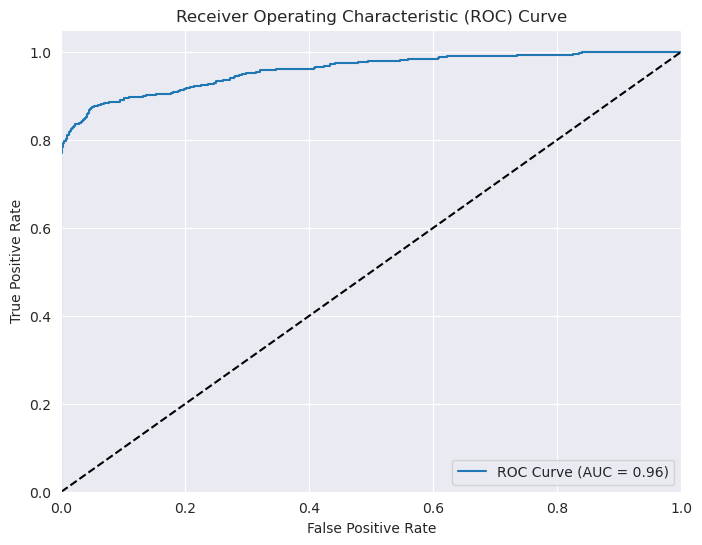

In [27]:
# Split the encoded train data into X & y
X_train = df_train_encoded.drop('Machine failure', axis=1)
y_train = df_train_encoded['Machine failure']

# Split the train data in train and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.2)

input_shape = (X_train.shape[1],)  # Creating a tuple with a single element

# Building the deep learning model
model = keras.Sequential([
    layers.Dense(units=64, activation='relu', input_shape= input_shape),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

# Compiling the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# This will run the model and plot the learning curve
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

y_pred = model.predict(X_valid)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_valid, y_pred)

print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The model appears to learn very well, not overfitting neither underfitting.

# Tuning
Now I'll try to tunning the model to achieve better results

In [28]:
input_shape = (X_train.shape[1])  # Creating a tuple with a single element

# Define a function that builds your Keras model with hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='binary_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='my_dir',  # Directory where logs and results will be stored
    project_name='my_project'  # Name for the tuning project
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 01m 23s]
binary_accuracy: 0.9961243271827698

Best binary_accuracy So Far: 0.996170163154602
Total elapsed time: 00h 11m 15s


In [29]:
# Build the best model using the best hyperparameters
best_model = build_model(best_hyperparameters)

# Train the best model with your training data
history_tuned = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

y_pred_tuned = model.predict(X_valid)

history_df_tuned = pd.DataFrame(history_tuned.history)

# Calculate the ROC curve
fpr2, tpr2, thresholds = roc_curve(y_valid, y_pred)

# Calculate the ROC AUC score
roc_auc_tuned = roc_auc_score(y_valid, y_pred)

print("ROC AUC Score:", roc_auc_tuned)

Epoch 1/200
214/214 [==============================] - 1s 3ms/step - loss: 0.1753 - binary_accuracy: 0.9703 - val_loss: 0.0600 - val_binary_accuracy: 0.9851
Epoch 2/200
214/214 [==============================] - 0s 2ms/step - loss: 0.0452 - binary_accuracy: 0.9889 - val_loss: 0.0312 - val_binary_accuracy: 0.9933
Epoch 3/200
214/214 [==============================] - 0s 2ms/step - loss: 0.0284 - binary_accuracy: 0.9945 - val_loss: 0.0243 - val_binary_accuracy: 0.9959
Epoch 4/200
214/214 [==============================] - 1s 3ms/step - loss: 0.0245 - binary_accuracy: 0.9957 - val_loss: 0.0226 - val_binary_accuracy: 0.9962
Epoch 5/200
214/214 [==============================] - 0s 2ms/step - loss: 0.0234 - binary_accuracy: 0.9960 - val_loss: 0.0220 - val_binary_accuracy: 0.9963
Epoch 6/200
214/214 [==============================] - 0s 2ms/step - loss: 0.0229 - binary_accuracy: 0.9961 - val_loss: 0.0216 - val_binary_accuracy: 0.9963
Epoch 7/200
214/214 [==============================] - 0s 

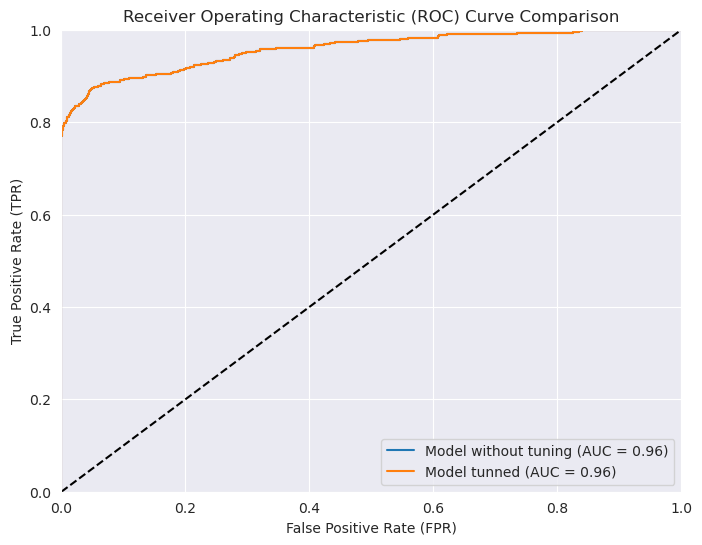

In [30]:
# Print both models to see if it has really improved
# Create a plot to compare the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model without tuning (AUC = {roc_auc:.2f})')
plt.plot(fpr2, tpr2, label=f'Model tunned (AUC = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Doesn't get any better, so I'll stick with the original model.

In [31]:
X_test = df_test_encoded

y_pred = model.predict(X_test)

# Flatten y_pred to make it 1-dimensional
y_pred = y_pred.flatten()

2843/2843 [==============================] - 3s 998us/step


In [32]:
submission_df = pd.DataFrame({
    'ID': ids.index,  # Replace 'ids' with your list or array of IDs
    'Machine failure': y_pred  # Replace 'Machine failure' with the appropriate column name
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Conclusion
The model achieves a really great performance of 95% of AUC ROC on the validation set, using Deep Learning Keras model.